In [1]:
import numpy as np
from collections import Counter

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

from numpy.lib.stride_tricks import sliding_window_view as ws_split
from skimage.filters import threshold_otsu

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score

from seaborn import heatmap
import numpy as np
import matplotlib.pyplot as plt

#import sys
#sys.path.append('/content/drive/MyDrive/TesisNotebooks')

from PQmodel import PQ
#from numba import jit

In [2]:
catalog=['Pure sinusoidal [0]', 'Sag[1]', 'Swell[2]','Interruption[3]','Transient/Impulse/Spike[4]',
         'Oscillatory transient [5]','Harmonics[6]','Harmonics with Sag[7]', 'Harmonics with Swell[8]',
         'Flicker[9]', 'Flicker with Sag[10]', 'Flicker with Swell[11]', 'Sag with Oscillatory transient[12]',
         'Swell with Oscillatory transient [13]', 'Sag with Harmonics [14]', 'Swell with Harmonics [15]', 'Notch [16]',
         'Harmonics with Sag with Flicker [17]', 'Harmonics with Swell with Flicker [18]',  'Sag with Harmonics with Flicker [19]',
         'Swell with Harmonics with Flicker [20]', 'Sag with Harmonics with Oscillatory transient [21]',
         'Swell with Harmonics with Oscillatory transient [22]', 'Harmonics with Sag with Oscillatory transient [23]',
         'Harmonics with Swell with Oscillatory transient [24]','Harmonics with Sag with Flicker with Oscillatory transient [25]',
         'Harmonics with Swell with Flicker with Oscillatory transient [26]', 'Sag with Harmonics with Flicker with Oscillatory transient [27]'
         'Swell with Harmonics with Flicker with Oscillatory transient [28]']

In [3]:
cicolosdist=10
Prueba = PQ(Cicles=cicolosdist,PeriodoDisturbio=cicolosdist,InicioDisturbio=0,FS=3841)

In [4]:
datos = Prueba.PQaleatorio(200)
datosp=  Prueba.PQaleatorio(1)
datos.shape

(200, 29, 640)

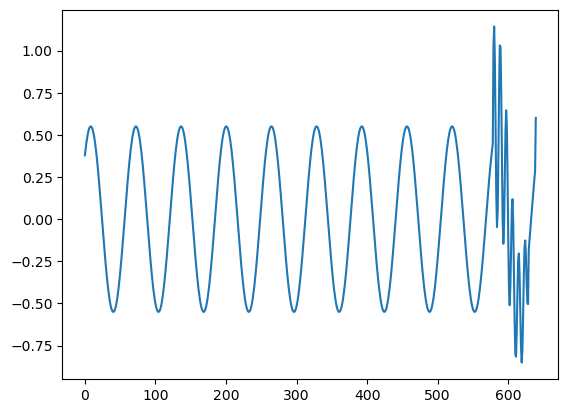

In [5]:
plt.plot(datos[1,5])
plt.show()

In [6]:
def cross_val2(model, X,y):

    skf=StratifiedKFold(n_splits=5, random_state=33, shuffle=True)
    yo,yp=[],[]
    i=1
    for ti,vi in skf.split(X, y):
        #print(vi.shape,y.shape)
        print(f"Fold: {i}")
        i+=1
        model.fit(X[ti],y[ti])
        yp+=list(model.predict(X[vi]))
        yo+=list(y[vi])
    return np.array(yp), np.array(yo)

def build_data(data,cs=16):
    Muestras,tSenal,LSenal=data.shape
    db,dbl=[],[]
    for j in range(Muestras):
        for k in range (tSenal):
            s = data[j,k]
            sd= ws_split(s,window_shape=cs)
            for iw in range(len(sd)):
                db.append(sd[iw])
                dbl.append(k)

    return np.array(db),np.array(dbl)

def build_dataClass(data,cs=16):
    Muestras,tSenal,LSenal=data.shape
    xt,yt1,yt2,yt3,yt4 = [],[],[],[],[]
    UFalla = 6  ##Denota un grupo de senales con una falla
    DFalla = 16 ##Denota el grupo de senales con dos fallas
    TFalla = 24 ##Denota el grupo de senales con tres fallas
    for j in range(Muestras):
        for k in range (tSenal):
            s = data[j,k]
            sd= ws_split(s,window_shape=cs)
            for iw in range(len(sd)):
                xt.append(sd[iw])
                if k <= UFalla or k==DFalla :
                    yt1.append(k)
                    yt2.append(0)
                    yt3.append(0)
                    yt4.append(0)
                elif k > UFalla and k < DFalla :
                    yt1.append(9)
                    yt2.append(k)
                    yt3.append(0)
                    yt4.append(0)
                elif k > DFalla  and k <= TFalla:
                    yt1.append(9)
                    yt2.append(0)
                    yt3.append(k)
                    yt4.append(0)
                elif k > TFalla :
                    yt1.append(9)
                    yt2.append(0)
                    yt3.append(0)
                    yt4.append(k)

    return np.array(xt),np.array(yt1),np.array(yt2),np.array(yt3),np.array(yt4)

In [7]:
dd,target1,target2,target3,target4=build_dataClass(datos,cs=128)
#dd2,target=build_data(datos,cs=128)

In [8]:
#dd,target1,target2,target3,target4=build_dataClass(datos,cs=128)


print(np.bincount(target1))

[ 102600  102600  102600  102600  102600  102600  102600       0       0
 2154600       0       0       0       0       0       0  102600]


In [9]:
def TrainModels(model, X,y,y1,y2,y3):
    model[0].fit(X,y)
    model[1].fit(X,y1)
    model[2].fit(X,y2)
    model[3].fit(X,y3)

    return model

In [10]:
model =[]
for v in range(5):
    model.append(KNeighborsClassifier())#=[KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier(),KNeighborsClassifier()]

In [11]:
modeltrain=TrainModels(model,dd,target1,target2,target3,target4)

In [12]:
def testmultiKNeighbors(model,X):
    yp,predict=[],[]
    for v in X:

        x = v.reshape(1,-1)
        predict=model[0].predict(x)

        if predict==9:
            predict=model[1].predict(x)
            
            if predict==0:
                predict=model[1].predict(x)

                if predict==0:
                    predict=model[2].predict(x)

                    if predict==0:
                        predict=model[3].predict(x)
                        yp+=list(predict)
                        #yo+=list(y)

                    else: 
                        #yo+=list(y)
                        yp+=list(predict)

                else: 
                    yp+=list(predict)
                    #yo+=list(y)

            else:
                yp+=list(predict)
                #yo+=list(y)

        else: 
            yp+=list(predict)
            #yo+=list(y)

    return yp


In [13]:
ddP,targetP=build_data(datosp,cs=128)

In [14]:
yp=testmultiKNeighbors(modeltrain,ddP) 

In [ ]:
np.array(yp).shape

(14877,)

In [ ]:
np.array(targetP).shape

(14877,)

In [ ]:
cmt =confusion_matrix(yp,targetP) 
f1_score(yp,targetP,average='weighted')

0.2826686749892024

<Axes: >

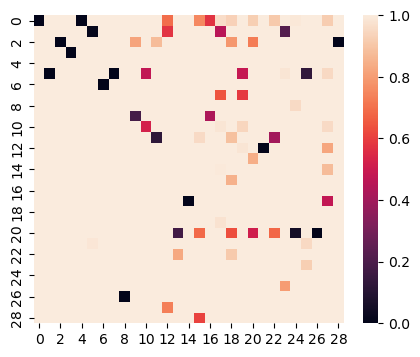

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
heatmap(1-cmt/np.bincount(targetP), ax=ax)

(128, 1)